In [1]:
import json

In [2]:
data = []
with open("./replays.json", 'r') as f:
    data = json.load(f)


In [77]:
replay_url = "https://wank.wavu.wiki/api/replays"
api_url = "https://wank.wavu.wiki/api"
unused_idxs = [25,26,27,30,31,37]


rank_mapping = {
    0: "Beginner",
    1: "1st Dan",
    2: "2nd Dan",
    3: "Fighter",
    4: "strategist",
    5: "combatant",
    6: "Brawler",
    7: "Ranger",
    8: "Cavalry",
    9: "Warrior",
    10: "Assailant",
    11: "Dominator",
    12: "Vanquisher",
    13: "Destroyer",
    14: "Eliminator",
    15: "Garyu",
    16: "Shinryu",
    17: "Tenryu",
    18: "Mighty Ruler",
    19: "Flame Ruler",
    20: "Battle Ruler",
    21: "Fujin",
    22: "Raijin",
    23: "Kishin",
    24: "Bushin",
    25: "Tekken King",
    26: "Tekken Emperor",
    27: "Tekken God",
    28: "Tekken God Supreme",
    29: "God of Destruction"
    }



playable_char_map = {
            0: "Paul",
            1: "Law",
            2: "King",
            3: "Yoshimitsu",
            4: "Hworang",
            5: "Ling",
            6: "Jin",
            7: "Bryan",
            8: "Kazuya",
            9: "Steve",
            10: "Jack",
            11: "Asuka",
            12: "Devil Jin",
            13: "Feng",
            14: "Lili",
            15: "Dragunov",
            16: "Leo",
            17: "Lars",
            18: "Alisa",
            19: "Caludio",
            20: "Shaheen",
            21: "Nina",
            22: "Lee",
            23: "Kuma",
            24: "Panda",
            25: "unknown1", # might be incorrectly set to zafina 
            26: "unknown2",
            27: "unknown3",
            28: "Zafina", #zafina?
            29: "Azucena", #might be incorrect
            30: "unknown4",
            31: "unknown5",
            32: "Jun",
            33: "Reina", #Reina?
            34: "Leroy", #Unknown2
            35: "Victor",
            36: "Raven", #raven?
            37: "unknown6",
            38: "Eddy", #eddy?
            39: "Lidia",
            40: "Heihachi"
        }

In [78]:
import re
import requests
from bs4 import BeautifulSoup
import heapq
import matplotlib.pyplot as plt
import numpy as np


def get_all_new_replays(url, data, url_latest): # url_latest: "https://wank.wavu.wiki/api", url: "#"https://wank.wavu.wiki/api/replays"
    
    break_point = 0
    for d in data:
        break_point = max(d["battle_at"], break_point)
    
    before = get_latest_api_entry(url_latest)
    replays = []
    log = 1
    
    while True:
        res = requests.get(url, params={"before": before}).json()
        if not res or before <= break_point:
            print(f"sth went wrong or reached the end\n"
                  f"new entries: {len(replays)}\n"
                  f"latest: {break_point}\n"
                  f"was searching for time: {before}")
            break
        
        replays.extend(res)
            
        before = min(float(r["battle_at"]) for r in res) - 700
        if log % 10 == 0:
            print(f"fetched {len(replays)}")
        
        log += 1
    
    return replays
        


def get_latest_api_entry(url): #"https://wank.wavu.wiki/api"
    text = ""

    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        
        main_section = soup.find("main", class_="document")
        if main_section:
            dl_tag = main_section.find("dl")
            if dl_tag:
                dd_tags = dl_tag.find_all("dd")
                text = dd_tags[0].text.strip()
            else:
                print("No <dl> tag found in <main class='document'>.")
        else:
            print("No <main class='document'> tag found.")
    else:
        print(f"Failed to fetch the page. Status code: {response.status_code}")
    
    m = re.search(r"default:\s*(\d+)", text)
    max_entry = 0
    
    if m:
        max_entry = m.group(1)

    return int(max_entry) if int(max_entry) > 0 else -1


def find_all_replays_for_id(player_id, data, player_polaris_id=None): # my id is 5r4gQ4RNgNQ4

    max_index = 40
    most_used = [0] * (max_index + 1)
    most_played_against = [0] * (max_index + 1)
    won = 0
    defect = 0
    raw_data = []

    for d in data:
        if not player_polaris_id:
            if d['p1_name'].lower() == player_id.lower():
                player_polaris_id = d["p1_polaris_id"]
            elif d['p2_name'].lower() == player_id.lower():
                player_polaris_id = d["p2_polaris_id"]
        else:            
            if d["p1_polaris_id"] == player_polaris_id:
                most_used[d["p1_chara_id"]] += 1
                most_played_against[d["p2_chara_id"]] += 1
                if d["winner"] == 1:
                    won += 1
            elif d["p2_polaris_id"] == player_polaris_id:
                most_used[d["p2_chara_id"]] += 1
                most_played_against[d["p1_chara_id"]] += 1
                if d["winner"] == 2:
                    won += 1
            
            raw_data.append(d)
                

    player_data = {"most_used_arr": most_used,
                "most_played_against": most_played_against,
                "win_rate": f"{won / (len(data) - defect) * 100}%"}

    
    return player_data, raw_data

def plot_user_most_played_against(user_data, playable_char_map, unused_idxs):
    x = [""] * (len(user_data["most_played_against"]))
    play_data = []
    
    for i, x in enumerate(user_data["most_played_against"]):
        heapq.heappush(play_data, (-x, i))

    x = []
    y = []
    
    while play_data:
        v, i = heapq.heappop(play_data)
        if i in unused_idxs:
            continue
        y.append(-v)
        x.append(playable_char_map[i])
        
    most_used_np = np.array(x)
    most_used_y = np.array(y)

    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(most_used_np))
    plt.bar(most_used_np, most_used_y, width=0.5)
    plt.xticks(x_positions, most_used_np, rotation=60)
    plt.show()


def plot_user_most_used_chars_data(user_data, playable_char_map, unsused_idxs):
    play_data = []
    
    for i, x in enumerate(user_data["most_used_arr"]):
        heapq.heappush(play_data, (-x, i))
    
    x = []
    y = []
    
    while play_data:
        v, i = heapq.heappop(play_data)
        if i in unsused_idxs:
            continue
        y.append(-v)
        x.append(playable_char_map[i])
    
    most_used_np = np.array(x)
    most_used_y = np.array(y)

    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(most_used_np))
    plt.bar(most_used_np, most_used_y, width=0.5)
    plt.xticks(x_positions, most_used_np, rotation=45)
    plt.title("character usage data")
    plt.show()


def find_char_popularity(data):
    
    char_data = [0] * 41
    not_found = set()
    flag = False
    for d in data:
        flag = False
        if d["p2_chara_id"] not in playable_char_map.keys():
            not_found.add(d["p2_chara_id"])
            flag = True
        
        elif d["p1_chara_id"] not in playable_char_map.keys():
            not_found.add(d["p1_chara_id"])
            flag = True
        
        if not flag:
            char_data[d["p1_chara_id"]] += 1
            char_data[d["p2_chara_id"]] += 1
    
    return char_data, list(not_found)


def plot_data(data, playable_char_map, unused_idxs):
    pop_data = []

    for i in range(len(data)):
        if i not in playable_char_map.keys() or i in unused_idxs:
            continue
        
        heapq.heappush(pop_data, (data[i] * -1, playable_char_map[i]))

    x = []
    y = []
    
    while pop_data:
        pop, char = heapq.heappop(pop_data)
        x.append(char)
        y.append(-1 * pop)

    most_used_np = np.array(x)
    most_used_y = np.array(y)

    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(most_used_np))
    plt.bar(most_used_np, most_used_y, width=0.5)
    plt.xticks(x_positions, most_used_np, rotation=45)
    plt.title("Character popularity")
    plt.show()


def get_ranked_data(data):
    
    rank_data = [0] * 30
    
    for d in data:
        rank_data[d['p1_rank']] += 1
        rank_data[d['p2_rank']] += 1
    
    return rank_data

def plot_rank_data(data, rank_mapping):
    x = [""] * 30
    y = [0] * 30
    
    for i in range(len(data)):
        x[i] = rank_mapping[i]
        y[i] = data[i]
    
    x = np.array(x)
    y = np.array(y)
    
    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(data))
    plt.bar(x, y, width=0.5)
    plt.xticks(x_positions, x, rotation=60)
    plt.show()


def update_local_json_replays(outpath, data):
    with open(outpath, 'w') as f:
        json.dump(data, f, indent=4)

In [5]:
new_data = get_all_new_replays("https://wank.wavu.wiki/api/replays", data, "https://wank.wavu.wiki/api")
# f = get_latest_api_entry("https://wank.wavu.wiki/api")

for nd in new_data:
    data.append(nd)

update_local_json_replays("./replays.json", data)

fetched 55034
sth went wrong or reached the end
new entries: 60559
latest: 1732210000
was searching for time: 1732209764.0


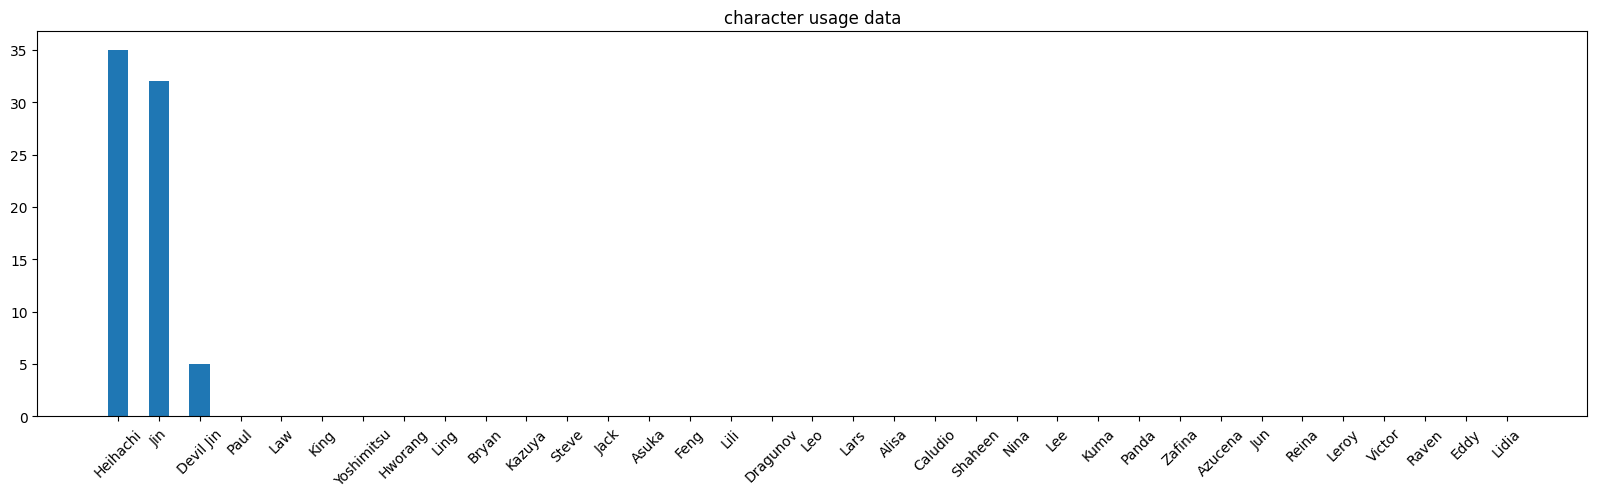

In [88]:
glonki_data, raw = find_all_replays_for_id("Glonki", data, "5r4gQ4RNgNQ4")
plot_user_most_used_chars_data(glonki_data, playable_char_map, unused_idxs)

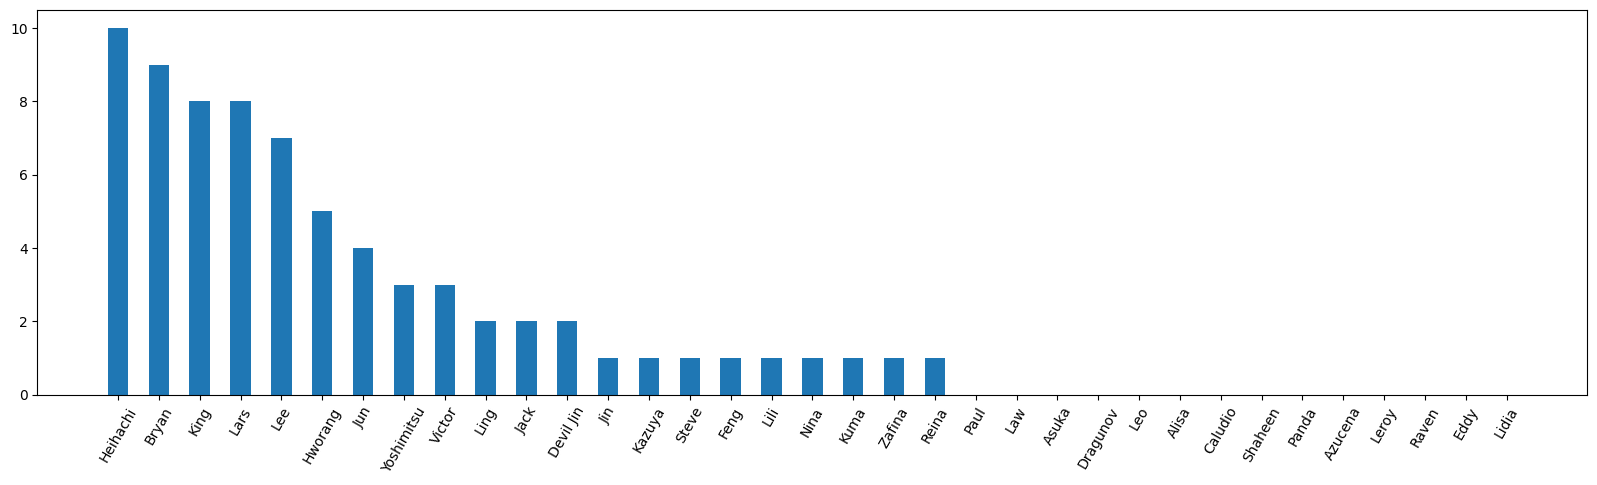

In [89]:
plot_user_most_played_against(glonki_data, playable_char_map, unused_idxs)

In [90]:
most_pop_data, _ = find_char_popularity(data)

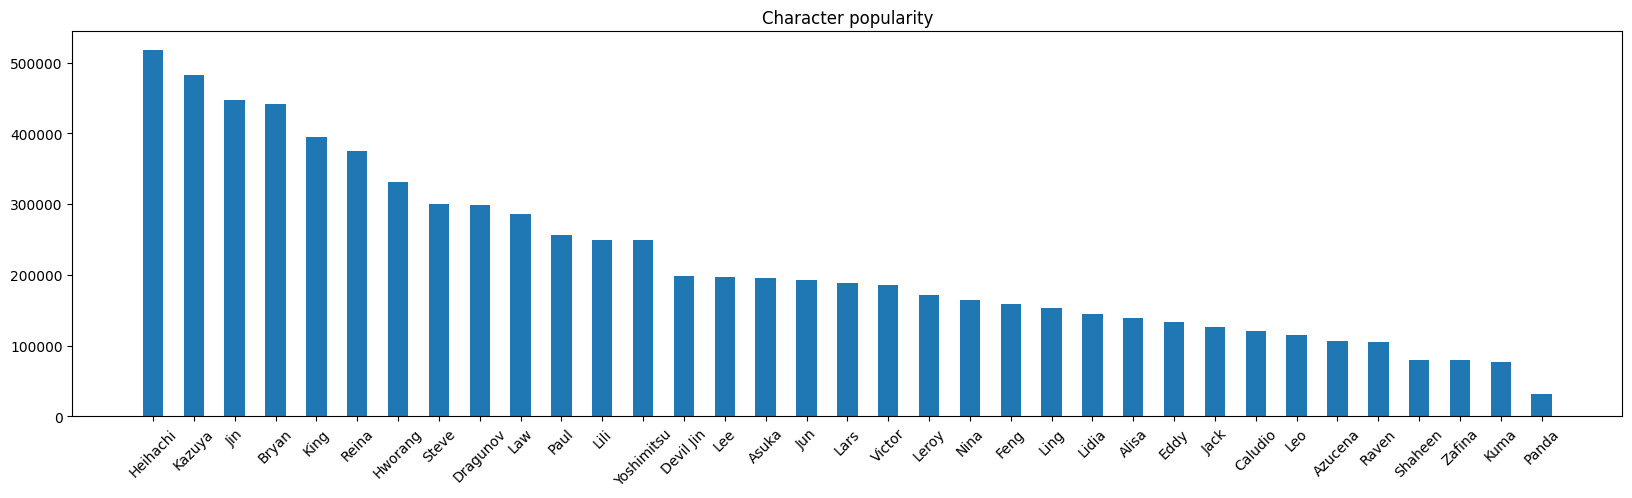

In [91]:
plot_data(most_pop_data, playable_char_map, unused_idxs)

In [92]:
rank_data = get_ranked_data(data)

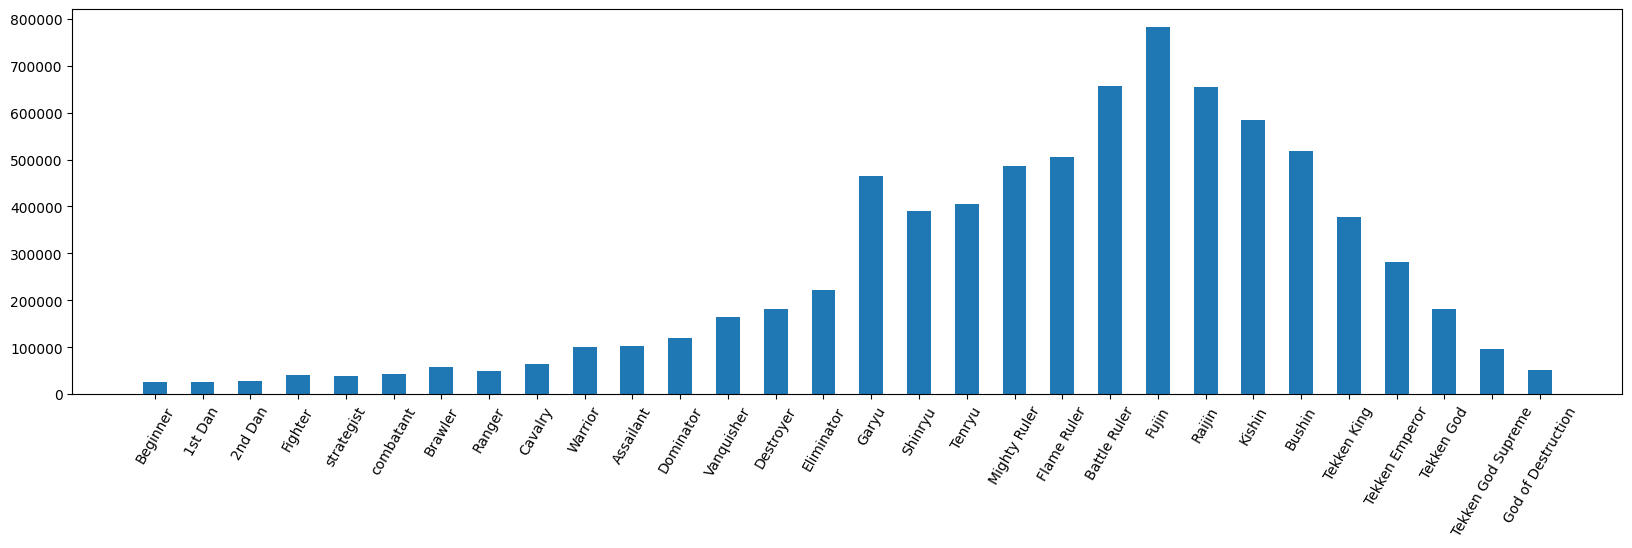

In [93]:
plot_rank_data(rank_data, rank_mapping)

In [94]:
# get_all_replays_of_user(replay_url, "themainmanswe", data)

In [95]:
# tmm = find_all_replays_for_id("TheMainManSWE", data)
# with open("./tmm_replay_data.json", 'w') as f:
#     json.dump(tmm, f, indent=4)

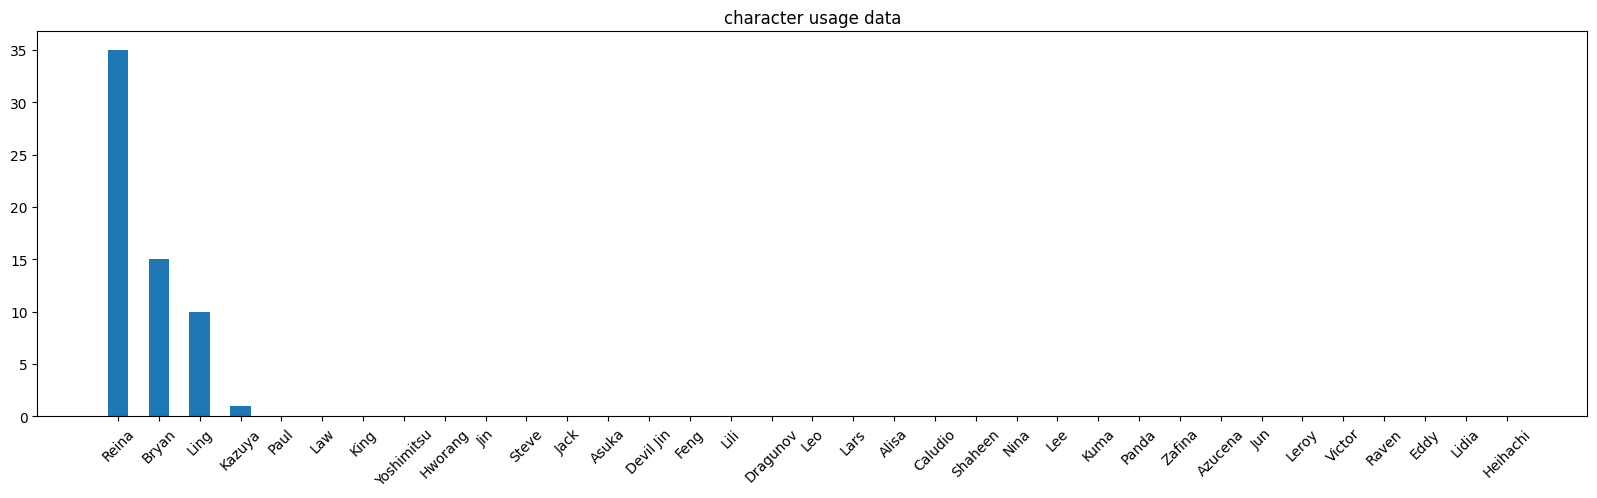

In [96]:
#find replays for a specific user
rando, _ = find_all_replays_for_id("ByShao", data, None)
plot_user_most_used_chars_data(rando, playable_char_map, unused_idxs)

In [97]:
break_point = 0

before = get_latest_api_entry(api_url)
replays = []
log = 1

while True:
    res = requests.get(replay_url, params={"before": before}).json()
    if not res or before == 0:
        print(f"sth went wrong or reached the end\n"
                f"new entries: {len(replays)}\n"
                f"latest: {break_point}\n"
                f"was searching for time: {before}")
        break
    
    replays.extend(res)
        
    before = min(float(r["battle_at"]) for r in res) - 700
    before = max(before, 0)
    if log % 10 == 0:
        print(f"fetched {len(replays)}")
    
    log += 1


with open("./replays.json", 'w') as f:
    json.dump(replays, f, indent=4)

KeyboardInterrupt: 